# Introduction

For a good functioning of this code it is necessary to have numpy 1.19.5.
A later version would cause a problem when changing a tensor into an array.


In [153]:
pip list

Package                      VersionNote: you may need to restart the kernel to use updated packages.

---------------------------- -------------------
absl-py                      0.15.0
aiohttp                      3.8.1
aiosignal                    1.2.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
astor                        0.8.1
astunparse                   1.6.3
async-timeout                4.0.1
asynctest                    0.13.0
attrs                        21.4.0
Babel                        2.9.1
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
blinker                      1.4
blis                         0.7.7
Bottleneck                   1.3.4
brotlipy                     0.7.0
bs4                          0.0.1
cachetools                   4.2.2
catalogue                    2.0.7
certifi                      2021.10.8
cffi                         1.15.0

## Importing librairies and downloading datasets:

Note that gensim 4.0.0 is not cmpatible with numpy 1.19.5, this is why we use gensim 4.0.1.

In [9]:
!pip install gensim==4.0.1
!pip install pandas==1.2.5

Here is the list of the librairies to import. 
Not all of them will be useful but I tried different models.

In [5]:
import os
import sys
import zipfile
import requests
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Machine Learning libraries
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.downloader as gloader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.math import reduce_mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Average, Add, Dot, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Bidirectional, Dense, Flatten 

nltk.download('punkt')
# nltk punkt is a tokenizer divides a text into a list of sentences.
nltk.download('stopwords')
# nltk stopwords is like a list of 'useless' words that do not influence the meaning of a sentence.

D:\anaconda\envs\Python3-7_Keras_env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\degui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\degui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now we can proceed and download the data:

In [12]:


df_train = pd.read_csv('train.tsv', delimiter='\t')
df_val = pd.read_csv('dev.tsv', delimiter='\t')
df_test = pd.read_csv('test.tsv', delimiter='\t')

"""
Let's display the head of the train data to have an idea of what is going on
"""

df_train.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,


# Data pre-processing:

## The NAN problem:

After studying the data, it became clear that the presence of NAN was a problem.

Having NAN means 2 things:
- coding problem since NAN means missing data.
- a logical problem: how can we judge a claim if we dont have an explanation ? a label ?
Therefore with the following code we get rid of the NANs.

In [14]:


df_train=df_train.dropna(subset=['claim', 'explanation', 'label', 'subjects'])
df_val=df_val.dropna(subset=['claim', 'explanation', 'label', 'subjects'])
df_test=df_test.dropna(subset=['claim', 'explanation', 'label', 'subjects'])



With the following code we can quickly check the effect of the dropna:

In [15]:


check = pd.isna(df_train["label"])
df_train[check]

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects


## classes distribution:

We want to have an idea of the number of 'true'/'false'/'mixture'/'unproven', therefore we display the classes distribution:

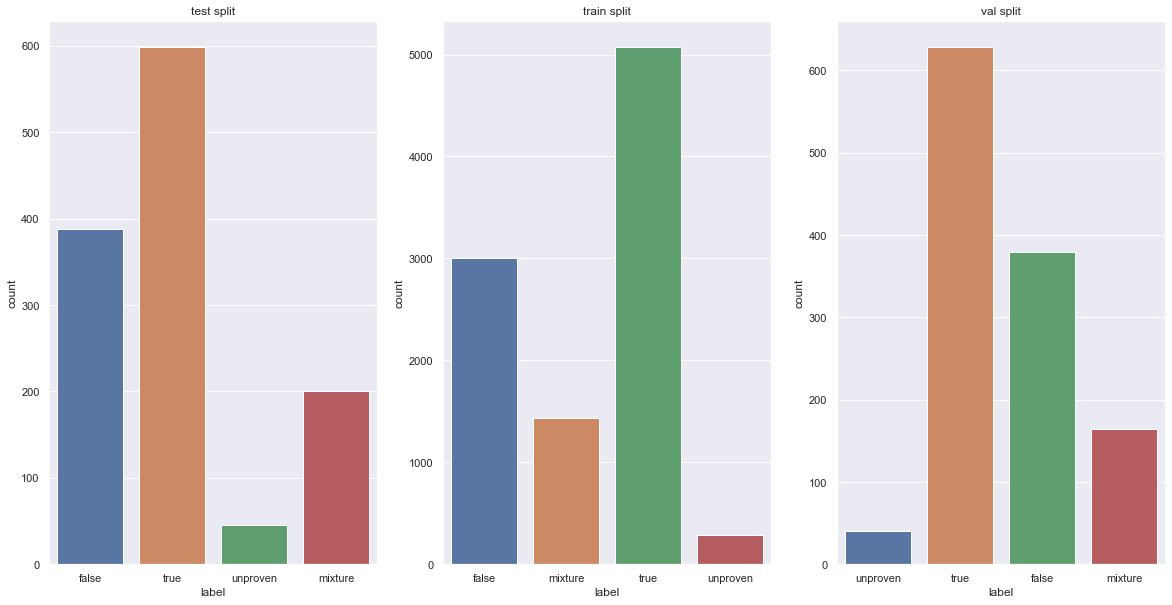

We notice a clear difference, we have about 50% of true, 30% of false and 20% of others. We also notice (which is normal), that the number of data in the from the train.tsv is much higher Let s show that difference with the following graph


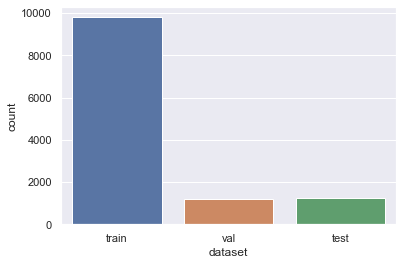

In [18]:

sns.set(color_codes=True)

concatenated = pd.concat([df_train.assign(dataset='train'),
                          df_val.assign(dataset='val'),
                          df_test.assign(dataset='test')])

_, axes = plt.subplots(1, 3, figsize=(20, 10))
for split, ax in zip(np.unique(concatenated['dataset'].values), axes.tolist()):
    ax.set_title(split + ' split')
    sns.countplot(x='label', data=concatenated[concatenated['dataset'] == split], ax=ax)
plt.show()

print('We notice a clear difference, we have about 50% of true, 30% of false and 20% of others. We also notice (which is normal), that the number of data in the from the train.tsv is much higher Let s show that difference with the following graph.')

sns.countplot(x='dataset', data=concatenated)
plt.show()


In the following cell, we want to deal with the 'unproven' and 'mixture'.

What is the truth ? I judge the truth as absolute in terms of fact checking, here is an exmple:
1) 'I have 2 CS PHd and I already hacked the Nasa' --> this sentence might be true but is clearly unproven
therefore we will classify the 'unproven' as 'false'.

2) 'I play football' --> this sentence is 'mixture' type because I actually play football, the english football: soccer
Therefore, because this type of misleading sentences, 'mixture' will be classified as 'false'.

Also, this method is very common in fact checking, as proven by the given ressources.

In [22]:


print(df_train['label'])

df_train['label'] = df_train['label'].replace({'mixture' : 'false', 'unproven' : 'false'})
df_val['label'] = df_val['label'].replace({'mixture' : 'false', 'unproven' : 'false'})
df_test['label'] = df_test['label'].replace({'mixture' : 'false', 'unproven' : 'false'})

print('')
print('After tansformation:')
print('')

print(df_train['label'])

0       false
1       false
2       false
3        true
4        true
        ...  
9827    false
9828     true
9829     true
9830    false
9831    false
Name: label, Length: 9804, dtype: object

After tansformation:

0       false
1       false
2       false
3        true
4        true
        ...  
9827    false
9828     true
9829     true
9830    false
9831    false
Name: label, Length: 9804, dtype: object


Now we can display the classes distribution to see the difference:

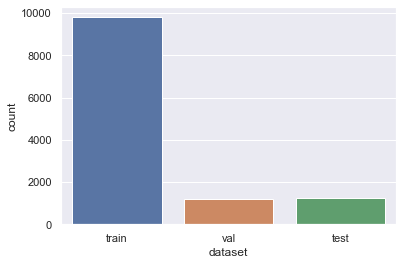

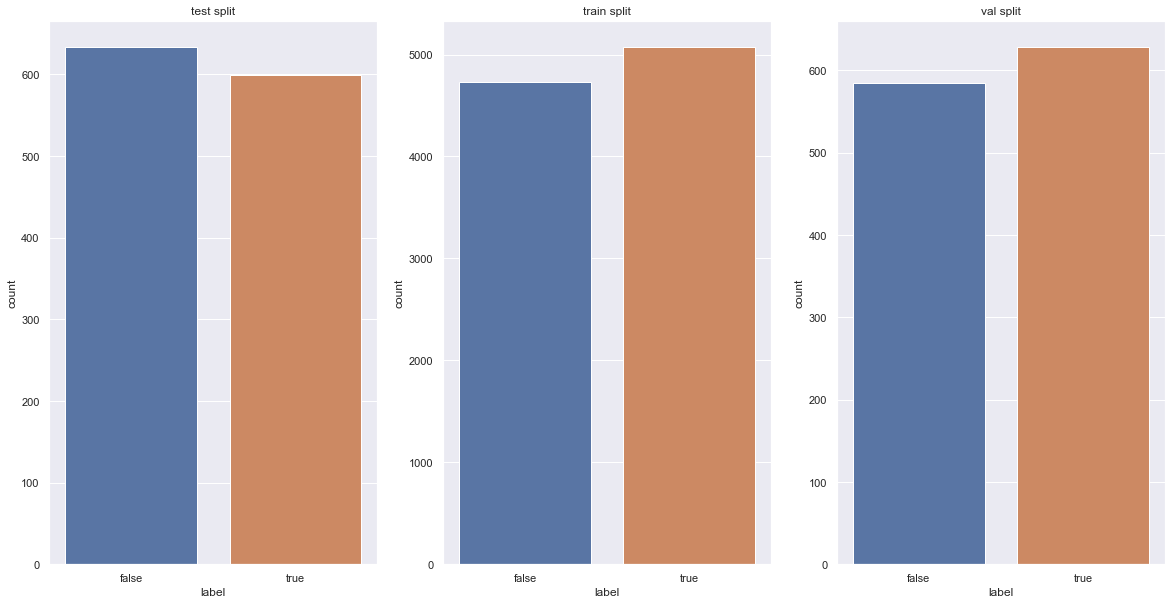

It can be noticed that the number of true and the number of false are almost equal, which is suitable.


In [24]:


sns.set(color_codes=True)

concatenated = pd.concat([df_train.assign(dataset='train'),
                          df_val.assign(dataset='val'),
                          df_test.assign(dataset='test')])

sns.countplot(x='dataset', data=concatenated)
plt.show()

_, axes = plt.subplots(1, 3, figsize=(20, 10))
for split, ax in zip(np.unique(concatenated['dataset'].values), axes.tolist()):
    ax.set_title(split + ' split')
    sns.countplot(x='label', data=concatenated[concatenated['dataset'] == split], ax=ax)
plt.show()

print('It can be noticed that the number of true and the number of false are almost equal, which is suitable.')

To solve the slight imbalance problem, we will still use a class weight during training.

## Data pre-prcessing and most used words:

Now we want to preprocess the sentences. By pronting the very first claim, we can notice numerous problems:
- the '...'
- the ""
- the ''
- the lowercases
With the following cells we will deal with the symbols.
Then, we will be able to change the texts into lists of tokens.



In [33]:
print (df_train['claim'][0])


def sentence_prep(text, pipeline, evidence=False, tokenizer=None):

    text = text.lower()
    for key, value in pipeline.items():
        text = key.sub(value, text)
        
    if evidence:
        text = " ".join(text.split()[1:])
    else:
        text = " ".join(text.split())
    if tokenizer:
        text = tokenizer(text) 
    return text

"The money the Clinton Foundation took from from foreign governments while Hillary Clinton was secretary of state ""is clearly illegal. … The Constitution says you can’t take this stuff."


With the next step, we are able to visualize the most used words.

We'll bring to lowercase everything and remove all the non-alphanumerical character.

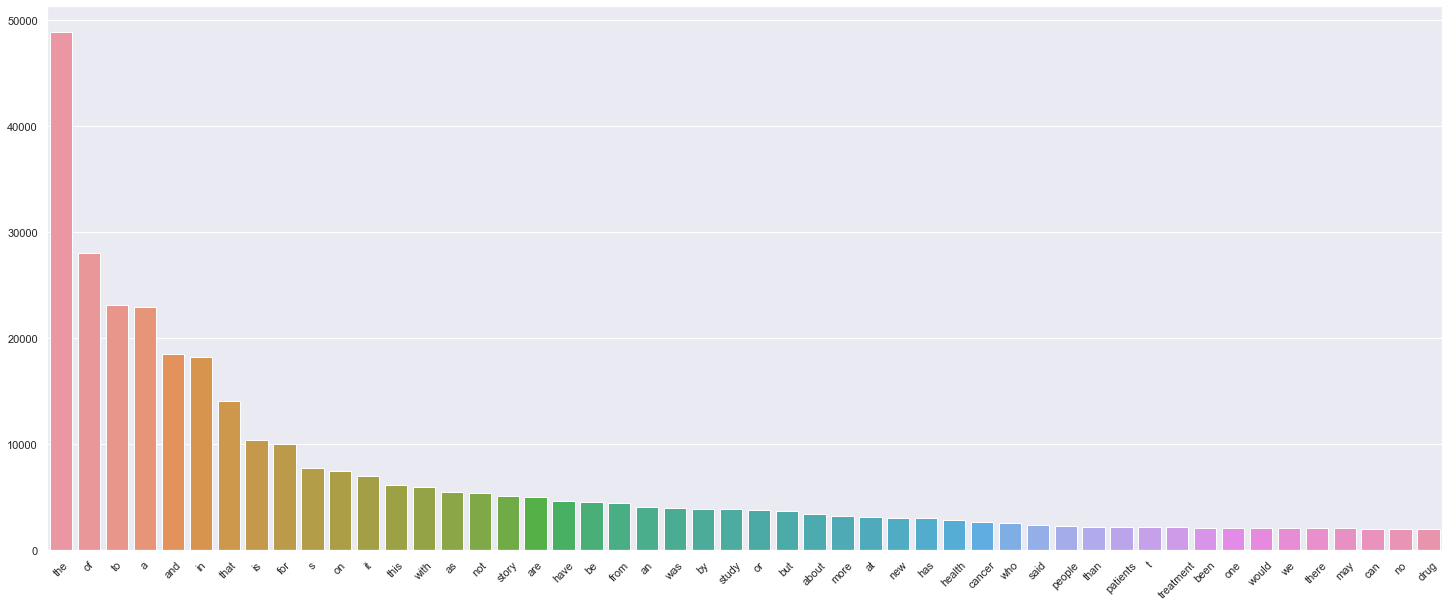

In [34]:


replace_others = re.compile('[^0-9a-zA-Z\s\']')

pipeline = {
    replace_others: ' ',
}

sentences = df_train['claim'].apply(sentence_prep, args=[pipeline]).to_list() \
                + df_train['explanation'].apply(sentence_prep, args=[pipeline, True]).to_list()
sentences = pd.Series(list(map(lambda x: x.split(' '), sentences))).explode() 

word_occurrence = sentences.value_counts()[:50]
_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=word_occurrence.keys(), y=word_occurrence.values, ax=ax)
plt.xticks(rotation=45)
plt.show()

We can already notice the presence of parenthesis and double quotes in the sentences displayd with the df.head, that we need to get rid of.

We will also use stopwords to have a better visualization of the other used words. However we just temporarily remove these words. We remove them temporarily because some stopwords include the negations, which are essential when judging a claim.

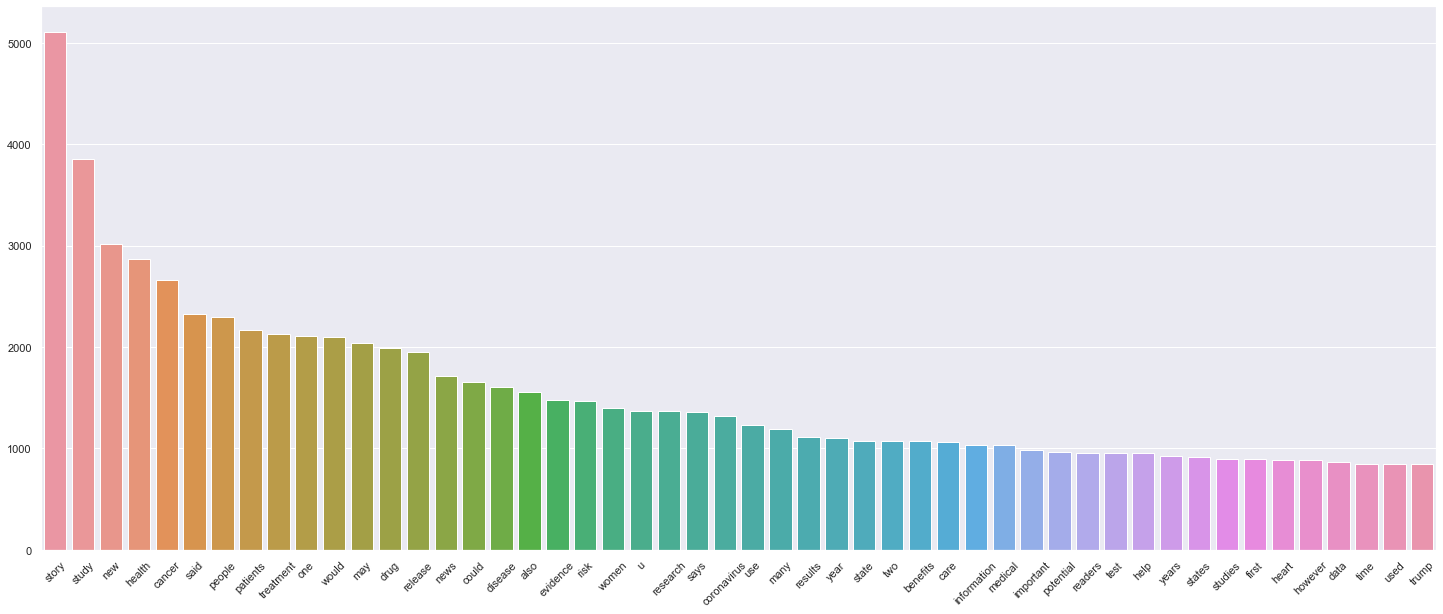

In [35]:


stop_words = set(stopwords.words('english'))
remove_par = re.compile('(-rrb-)|(-lrb-)')
remove_quotes = re.compile('(\'\'+)')
pipeline = {
    remove_par: ' ',
    remove_quotes: '',
    replace_others: ' ',
}

sentences = df_train['claim'].apply(sentence_prep, args=[pipeline]).to_list() \
                + df_train['explanation'].apply(sentence_prep, args=[pipeline, True]).to_list()
sentences = pd.Series(list(map(lambda x: x.split(' '), sentences))).explode()   
sentences = sentences[sentences.apply(lambda x: x not in stop_words)]

word_occurrence = sentences.value_counts()[:50]
_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=word_occurrence.keys(), y=word_occurrence.values, ax=ax)
plt.xticks(rotation=45)
plt.show()

We will erase the remaining symbols in the next cell.

### Inputs:

We also use the predefined function to get a list of strings countaining only one word each. This preprocessing is essential and we use it for both the claims and the explanations.

In [36]:


replace_others = re.compile('[^0-9a-zA-Z\s\']')
replace_par = re.compile('(-rrb-)|(-lrb-)')
replace_phonetics = re.compile('(-lsb-.*-rsb-)')
replace_quotes = re.compile('(\'\'+)')

pipeline = {
    replace_phonetics: '',
    replace_quotes: '',
    replace_par: ' ',
    replace_others: ' '
}


tokenizer = lambda x: x.split(' ')
X_train_claim_pre = df_train['claim'].apply(sentence_prep, args=[pipeline, False, tokenizer])
X_train_evidence_pre = df_train['explanation'].apply(sentence_prep, args=[pipeline, True, tokenizer])

X_val_claim_pre = df_val['claim'].apply(sentence_prep, args=[pipeline, False, tokenizer])
X_val_evidence_pre = df_val['explanation'].apply(sentence_prep, args=[pipeline, True, tokenizer]) 

X_test_claim_pre = df_test['claim'].apply(sentence_prep, args=[pipeline, False, tokenizer])
X_test_evidence_pre = df_test['explanation'].apply(sentence_prep, args=[pipeline, True, tokenizer]) 
print(X_train_claim_pre)

0       [the, money, the, clinton, foundation, took, f...
1       [annual, mammograms, may, have, more, false, p...
2       [sbrt, offers, prostate, cancer, patients, hig...
3       [study, vaccine, for, breast, ovarian, cancer,...
4       [some, appendicitis, cases, may, not, require,...
                              ...                        
9827    [the, sturgis, motorcycle, rally, in, 2020, re...
9828    [astrazeneca's, infant, respiratory, drug, pri...
9829    [testicular, cancer, deaths, double, with, aft...
9830    [the, fda, published, conclusive, proof, that,...
9831    [on, whether, he, wrote, a, provision, that, a...
Name: claim, Length: 9804, dtype: object


We download the pre-trained GloVe embeddings (from gensim).
Ultimately we want to create the token vocabulary, that will be used in the indexing of the embedding matrix.

In [39]:


def glove(embedding_dimension=50):
    """
    Parameters:
    embedding_dimension: {50, 100, 200, 300}, default: 50
    
    Returns:
    gensim.models.keyedvectors
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_mod = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name")
        print("Glove: 50, 100, 200, 300")
        raise e
    return emb_mod

EMBEDDING_DIM = 300
gloves = glove(EMBEDDING_DIM)

We can now generate the sequences that we will feed to the network. To do so we are now going to create the token vocabulary, that will be used in the indexing of the embedding matrix.
This is why we are using the Tokenizer class of Keras.
We will use the fit_on_texts method on the GloVe's keys and on the training sentences. This is very important since we want to randomly instantiate the embeddings for words in the training set but not in GloVe. 

In [42]:


word_tok = Tokenizer(oov_token='<UNK>', filters=[])

word_tok.fit_on_texts(gloves.key_to_index.keys())

word_tok.fit_on_texts(X_train_claim_pre)
word_tok.fit_on_texts(X_train_evidence_pre)

X_train_claim_enc = word_tok.texts_to_sequences(X_train_claim_pre)
X_train_evidence_enc = word_tok.texts_to_sequences(X_train_evidence_pre)

X_val_claim_enc = word_tok.texts_to_sequences(X_val_claim_pre)
X_val_evidence_enc = word_tok.texts_to_sequences(X_val_evidence_pre)

X_test_claim_enc = word_tok.texts_to_sequences(X_test_claim_pre)
X_test_evidence_enc = word_tok.texts_to_sequences(X_test_evidence_pre)


print(len(word_tok.word_index))
print('')
print(X_train_evidence_enc[0])

402618

[37, 2, 296, 1013, 569, 459, 22, 22, 1694, 2231, 103, 810, 296, 24, 1990, 3, 95, 13, 9, 574, 1116, 2, 4288, 73, 122, 49, 42, 231, 14, 4049, 5, 10754, 7, 2, 4288, 64, 5367, 71, 11, 195, 88, 16, 652, 1990, 3, 95, 810, 296, 22, 1385, 6521, 27, 25969, 22, 1694, 2231, 28, 2, 6521, 7, 14, 197, 56, 2111, 22, 1694, 2231, 8, 1021, 4, 2, 296, 1013, 17, 810, 296, 213, 24, 17, 307, 3, 2, 1013, 148, 2859, 6789, 103, 213, 24, 1990, 3, 95, 64, 8, 6979, 2, 4288, 52, 15658, 7496, 6035, 225, 191, 155, 13, 157, 142, 60, 655, 19, 2659, 76, 11, 180, 9, 47, 9, 1538, 10, 20680, 6, 2, 2111, 19, 964, 28, 574, 1116, 2, 1178, 9, 14, 5, 13455, 307, 3, 71, 11, 6035, 225]


We the following sequence, we are simply changing the list of strings into sequences of numbers: we are padding.
During the padding of the sequences we want to zero-pad the encoded sequences based on the model architecture for the simple reason that they have different lengths. Note that the pad values will be masked out and discarded during the training.

In [52]:


class PadSequences:
    def __init__(self, train_claim, train_evidence):

        self.max_len = self._get_max_seq_lenght(train_claim, train_evidence)

    def _get_max_seq_lenght(self, claims, evidence):
        max_claim = max(map(lambda x: len(x), claims))
        max_evidence = max(map(lambda x: len(x), evidence))
        max_seq_len = max(max_claim, max_evidence)
        return max_seq_len
    
    def pad_seqs(self, claims, evidences, mode='other'):
        """
        Special case with mlp, that need to be padded accorind to the maximum sentence length found in the training set, 
        and not ccording to their own maximum length like the others

        """
        if mode == 'mlp':
            padded_claims = pad_sequences(claims, maxlen=self.max_len, padding='post')
            padded_evidences = pad_sequences(evidences, maxlen=self.max_len, padding='post')
        else:
            max_claim = max(map(lambda x: len(x), claims))
            max_evidence = max(map(lambda x: len(x), evidences))
            padded_claims = pad_sequences(claims, maxlen=max_claim, padding='post')
            padded_evidences = pad_sequences(evidences, maxlen=max_evidence, padding='post')
        return (padded_claims, padded_evidences)
    
padding_helper = PadSequences(X_train_claim_enc, X_train_evidence_enc)

X_train_claim_pad, X_train_evidence_pad = padding_helper.pad_seqs(X_train_claim_enc, X_train_evidence_enc)
X_val_claim_pad, X_val_evidence_pad = padding_helper.pad_seqs(X_val_claim_enc, X_val_evidence_enc)
X_test_claim_pad, X_test_evidence_pad = padding_helper.pad_seqs(X_test_claim_enc, X_test_evidence_enc)

X_train_claim_pad_mlp, X_train_evidence_pad_mlp = padding_helper.pad_seqs(X_train_claim_enc, X_train_evidence_enc, mode='mlp')
X_val_claim_pad_mlp, X_val_evidence_pad_mlp = padding_helper.pad_seqs(X_val_claim_enc, X_val_evidence_enc, mode='mlp')
X_test_claim_pad_mlp, X_test_evidence_pad_mlp = padding_helper.pad_seqs(X_test_claim_enc, X_test_evidence_enc, mode='mlp')


print(X_train_claim_pad)

[[   2  459    2 ...    0    0    0]
 [1158 1614   48 ...    0    0    0]
 [4974  707  282 ...    0    0    0]
 ...
 [9261   35  184 ...    0    0    0]
 [   2  242  221 ...    0    0    0]
 [  12  136   81 ...    0    0    0]]


Now that we took care of our inputs, we must focus on our targets.

### Targets:

We want to translate all the 'false' into 0 and all the 'true' int 1.
That way, we will be able to conceive a binary model using numbers.

We also need to change the target dtype to int64. 
(no particular reasons but if I dont I get an error when training my models).

In [53]:


y_mapping = { 'true' : '1'  , 'false' : '0'}
y_train_enc = df_train['label'].apply(lambda x: y_mapping[x])
y_val_enc = df_val['label'].apply(lambda x: y_mapping[x])
y_test_enc = df_test['label'].apply(lambda x: y_mapping[x])


print('y_test enc before transformaton:')
print('')
print(y_test_enc)

y_train_enc=y_train_enc.astype(str).astype('int64')
y_val_enc=y_val_enc.astype(str).astype('int64')
y_test_enc=y_test_enc.astype(str).astype('int64')

print('')
print('')
print('y_test enc after transformaton:')
print('')
print(y_test_enc)

y_test enc before transformaton:

0       0
1       1
2       1
3       0
4       0
       ..
1230    1
1231    1
1232    0
1233    1
1234    1
Name: label, Length: 1233, dtype: object


y_test enc after transformaton:

0       0
1       1
2       1
3       0
4       0
       ..
1230    1
1231    1
1232    0
1233    1
1234    1
Name: label, Length: 1233, dtype: int64


## Embedding:

Since we are going to use an embedding layer in our model, we need to create an embedding matrix
we are using the GloVes embeddings.
Let's compute first the max value and min value, respectively the vectors containing the element wise maximum and minimum among all the GloVe embeddings. They are very important because they will be used as the bounds of every random values assigned to each dimension of new random embeddings.

In [72]:


max_v = np.ones(EMBEDDING_DIM)*-sys.float_info.max
min_v = np.ones(EMBEDDING_DIM)*sys.float_info.max
for emb in gloves.vectors:
    max_v = np.maximum(max_v, emb)
    min_v = np.minimum(min_v, emb)

def build_matrix_embedding(embeddings, embedding_size, word_to_idx):

    vocab_size = len(word_to_idx.keys()) + 1 
    embedding_matrix = np.zeros(
        (vocab_size, embedding_size), 
        dtype=np.float32)
        
    for word, idx in tqdm(
        word_to_idx.items(), 
        desc='Building embedding matrix..'):
        try:
            embedding_vector = embeddings[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=min_v, high=max_v, size=embedding_size) 

        embedding_matrix[idx] = embedding_vector
    return embedding_matrix

In [73]:
embeddings = build_matrix_embedding(gloves, EMBEDDING_DIM, word_tok.word_index)

Building embedding matrix..: 100%|██████████| 402618/402618 [00:01<00:00, 347402.27it/s]


# Keras Model:

The following cell wll return when called a keras Model:

In [166]:
id_val = df_val['claim_id'].values
id_test = df_test['claim_id'].values



def get_model(vocab_size, mode, combine, embeddings, max_len=None, cosine=False, trainable=False, dropout=0.0):


    if mode == 'mlp':
        assert max_len, 'You must define the maximum lenght dimensions if \'mlp\' mode is chosen'

    # We take care of the inputs and their shape
    input_claims = Input(shape=(max_len,))
    input_evidence = Input(shape=(max_len,))
    
    # We create an embedding layer to convert each word into a fixed length vector of defined size
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True, weights=[embeddings], trainable=trainable)
    claims_emb = embedding_layer(input_claims)
    evidence_emb = embedding_layer(input_evidence)
    
    # We add a dropout because we may have some overfitting, and a dropout layer is a good way to prevent it   
    if dropout:
        dropout_layer = Dropout(dropout)
        claims_emb = dropout_layer(claims_emb)
        evidence_emb = dropout_layer(evidence_emb) 
        
    # We create a different model depending on its type (we have several models to train):
    if mode == 'last_state_rnn':
        rnn = Bidirectional(LSTM(units=256, dropout=dropout))
        print(type(rnn))
        print(type(claims_emb))
        claims_enc = rnn(claims_emb)
        evidence_enc = rnn(evidence_emb)

    elif mode == 'mlp':
        dense = Dense(256, activation='relu')
        print(claims_emb.shape, evidence_emb.shape)
        claims_enc = dense(Flatten()(claims_emb))
        evidence_enc = dense(Flatten()(evidence_emb))

    elif mode == 'bag_of_vectors':
        claims_enc = reduce_mean(claims_emb, axis=1)
        evidence_enc = reduce_mean(evidence_emb, axis=1)

    if combine == 'concat':
        x = Concatenate()([claims_enc, evidence_enc])
        
    if dropout:
        x = Dropout(dropout)(x)
    
    cosine_msg = '_cosine' if cosine else ''
    if cosine:
        cos_sim = Dot(axes=(1, 1),normalize=True)([claims_enc, evidence_enc])
        x = Concatenate()([x, cos_sim])

    # This last layer takes care of the final output that need to have a certain shape: (Nonce ,1)
    # Sigmoid can be replaced by Softmax but we don't need to do that since our loss function is binary.
    x = Dense(1, activation='sigmoid')(x)
    
    return Model([input_claims, input_evidence], x, name=mode+'_'+combine+cosine_msg)

Here we compute the 'voting scores' which correspond to the scores we get when grouping the pair claim/explanation

In [111]:


def compute_y_voting(y_true, y_pred, ids):

    y_voting = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'idx': ids})
    y_voting = y_voting.groupby('idx').agg(pd.Series.mode)
    y_voting_pred = y_voting['y_pred'].apply(lambda x: x[1] if isinstance(x, np.ndarray) else x).values
    y_voting_true = y_voting['y_true'].apply(lambda x: x[1] if isinstance(x, np.ndarray) else x).values
    return y_voting_true, y_voting_pred

Now we can ompute the voting mertrics of the validation data, the following class is a Callback subclass that implements the voting metrics strategy.
With this, we should be able to have predictions of the validation dataset grouped by IDs after every epochs.

In [112]:

class VotingMetrics(Callback):
    def __init__(self, val_data):

        super(Callback, self).__init__()
        self.X_val = val_data[0]
        self.y_val = val_data[1]
        self.id_val = val_data[2]

    def on_end_of_epoch(self, epoch, logs=None):

        y_pred = np.asarray(self.model.predict(self.X_val))
        y_pred = np.where(y_pred < 0.5, 0, 1).ravel()
        y_voting_true, y_voting_pred = compute_y_voting(self.y_val, y_pred, self.id_val)
        
        val_accuracy_voting = accuracy_score(y_voting_true, y_voting_pred)
        logs['val_accuracy_voting'] = val_accuracy_voting

## Run model: 

Batch size and number of epochs are decided quite arbitrarily, but they work.
With 9804 claims and with batch size of 128, we expet 9804/128=77 steps per epochs (9804 being the number of rows of the inputs).

In [64]:
batch_size = 128
epochs = 100
models = {}
histories = {}

We compile and run the training of the model thanks to the following function:
We also save the results for plotting.

In [67]:


def run_model(model, models, histories):

    if 'mlp' in model.name:
        X_data = [X_train_claim_pad_mlp, X_train_evidence_pad_mlp]
        X_data_val = [X_val_claim_pad_mlp, X_val_evidence_pad_mlp]
    else:
        X_data = [X_train_claim_pad, X_train_evidence_pad]
        X_data_val = [X_val_claim_pad, X_val_evidence_pad]
    models[model.name] = model
    optimizer = Adam(clipnorm=1)
    
    #The Adam optimizer in the most used optimizer for sentences classification. Clipnorm scales teh gradient of this optimizer
    #The results of this optimizer have faster computation time, and require fewer parameters for tuning.
    #Since our target is similar to a list of 0 and 1, we use the the 'binar_crossentropy' loss function.
    
    models[model.name].compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    models[model.name].summary()
    early_stop = EarlyStopping(monitor="val_accuracy",
                        patience=3,
                        mode="max",
                        restore_best_weights=True)
    voting_metrics = VotingMetrics((X_data_val, y_val_enc, id_val))
    histories[model.name] = models[model.name].fit(X_data, y_train_enc, batch_size=batch_size, epochs=epochs, class_weight=class_weights, validation_data=(X_data_val, y_val_enc), callbacks=[voting_metrics, early_stop])

Also, since the number of 'true' and the number of 'false' is different in every datasets, we compute a class_weight in order to prevent an imbalance of the results.

In [77]:
class_weights = compute_class_weight(class_weight='balanced', 
                                    classes=np.unique(y_train_enc), 
                                     y=y_train_enc)
class_weights = {i:class_weights[i] for i in range(2)}
print(class_weights)

{0: 1.037240795598815, 1: 0.9653406853091768}


# The models:

Now we run 3 models:
- las_rnn_state
- mlp
- bag_of_vector

In [78]:
modellsr = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode='last_state_rnn', 
                  combine='concat', 
                  embeddings=embeddings)
run_model(modellsr, models, histories)

<class 'tensorflow.python.keras.layers.wrappers.Bidirectional'>
<class 'tensorflow.python.framework.ops.Tensor'>
Model: "last_state_rnn_concat"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    120785700   input_5[0][0]                    
                                                                 input_6[0][0]                    
________________________________________________________________

In [79]:
model_mlp = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode='mlp', 
                  combine='concat', 
                  embeddings=embeddings,
                  max_len=len(X_train_claim_pad_mlp[0]))
run_model(model_mlp, models, histories)

(None, 692, 300) (None, 692, 300)
Model: "mlp_concat"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 692)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 692)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 692, 300)     120785700   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 207600)       0 

In [167]:
modelbov = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode='bag_of_vectors', 
                  combine='concat', 
                  embeddings=embeddings)
run_model(modelbov, models, histories)

Model: "bag_of_vectors_concat"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 300)    120785700   input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Mean_2 (TensorFlowO [(None, 300)]        0           embedding_5[0

## Ploting and displaying functions:

In the next few cells we are writing functions to display the results.

With the following function, we create 2 plots for each models, giving the evolution of the accuracy and the loss as a function of the epochs.

In [144]:


def plt_accuracy_loss(history, model_name):

    figsize = 16
    _, axes = plt.subplots(1, ncols=2, figsize=(figsize, 4))
    steps = len(history['loss'])
    early_stop = steps - 4
    for ax, name in zip(axes, ['loss', 'accuracy']):
        relevant_keys = [key for key in history.keys() if name in key]
        plot_name = name 

        columns = ['train', 'val'] 
        data_plot = pd.DataFrame(np.array([history[key] for key in relevant_keys]).T, columns=columns)
        sns.lineplot(data=data_plot, ax=ax)
        ax.axvline(early_stop, color='red', linestyle='--')
        ax.set_xlabel('epoch')

        ax.set_ylabel(plot_name)
        ax.set_title(plot_name)

      
    plt.suptitle('Plot for model '+ model_name)
    plt.tight_layout()
    plt.show()

With this cell we are displaying the classification report with a voting metric. The .from_predictions allows to plot the confusion matrices of the results.

In [161]:


def show_results(y_true, y_pred, ids):

    y_true_voting, y_pred_voting = compute_y_voting(y_true, y_pred, ids)

    report1 = classification_report(y_true, y_pred)
    report2 = classification_report(y_true_voting, y_pred_voting)
    reports = [report.split("\n") for report in [report1, report2]]

    results = ''
    for elems in zip(*reports):
        results += '\t\t'.join(elems) + '\n'
    results = '\t\t\t Standard Report \t\t\t\t\t\t Voting Report\n' + results
    print(results)
    fig, ax = plt.subplots(1, 2, figsize=(12, 10))
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                                   normalize='true', 
                                                   display_labels=['true', 'false'], 
                                                   include_values=False, 
                                                   cmap=plt.cm.Greens,
                                                   ax=ax[0], colorbar=False)
    disp = ConfusionMatrixDisplay.from_predictions(y_true_voting, y_pred_voting,
                                                   normalize='true', 
                                                   display_labels=[ 'true','false'], 
                                                   include_values=False, 
                                                   cmap=plt.cm.Greens,
                                                   ax=ax[1], colorbar=False)
    cmap = plt.cm.Greens
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
    plt.tight_layout()
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='bottom', shrink=0.6)                                  
    ax[0].set_title('Standard Confusion Matrix')
    ax[1].set_title('Voting Confusion Matrix')
    plt.show()

The following function evaluates all the model trained:

In [146]:

def evaluation_of_the_models(models, histories):

    for model_name, history in histories.items():
        plt_accuracy_loss(history.history, model_name)
    for model_name in models.keys():
        if 'mlp' in model_name:
            X = [X_val_claim_pad_mlp, X_val_evidence_pad_mlp]
        else:
            X = [X_val_claim_pad, X_val_evidence_pad]
        y_pred = models[model_name].predict(X, batch_size=batch_size)
        y_pred = np.where(y_pred < 0.5, 0, 1).ravel()
        print("="*60, '\n', 'Showing results for model ', model_name, '\n', "="*60, '\n')
        show_results(y_val_enc, y_pred, id_val)

Finally, the following function shows the results of the chosen model:

In [157]:

def test(model):

    if 'mlp' in model.name:
        X = [X_test_claim_pad_mlp, X_test_evidence_pad_mlp]
    else:
        X = [X_test_claim_pad, X_test_evidence_pad]
    y_pred = model.predict(X, batch_size=batch_size)
    y_pred = np.where(y_pred < 0.5, 0, 1).ravel()
    print("="*60, '\n', 'Showing results for model ', model.name, '\n', "="*60, '\n')
    show_results(y_test_enc, y_pred, id_test)

# Results:

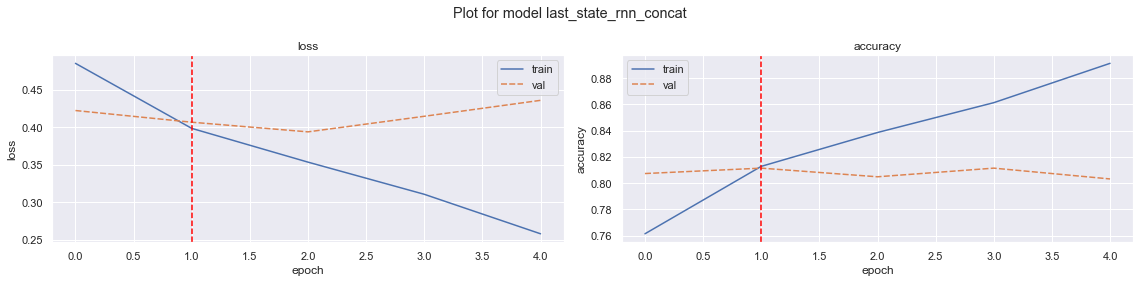

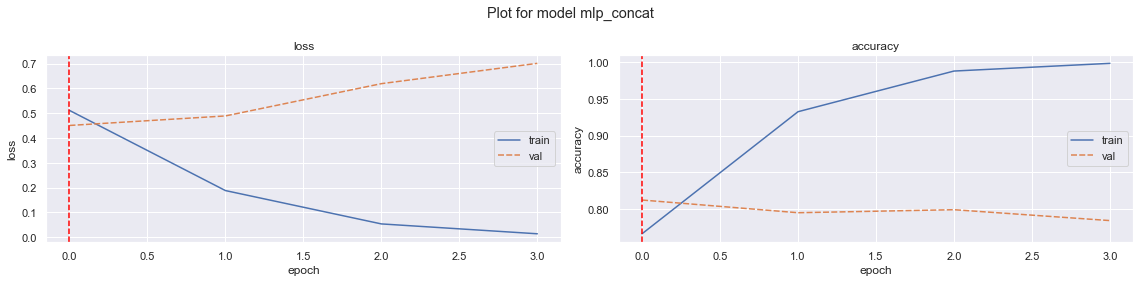

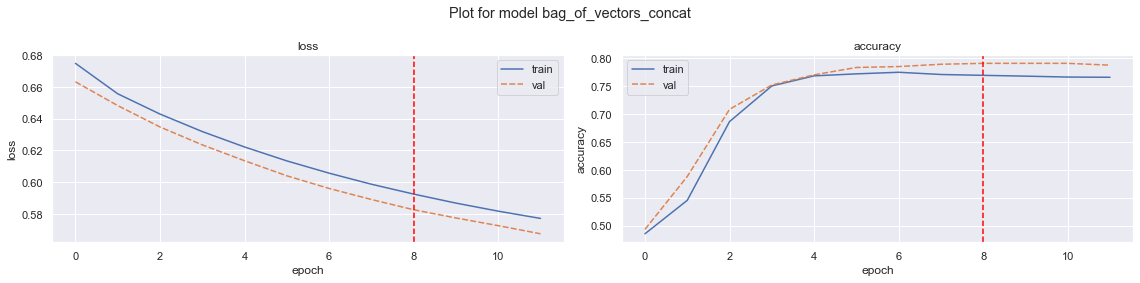

 Showing results for model  last_state_rnn_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.77      0.88      0.82       585		           0       0.77      0.88      0.82       585
           1       0.87      0.75      0.80       629		           1       0.87      0.75      0.80       629
		
    accuracy                           0.81      1214		    accuracy                           0.81      1214
   macro avg       0.82      0.81      0.81      1214		   macro avg       0.82      0.81      0.81      1214
weighted avg       0.82      0.81      0.81      1214		weighted avg       0.82      0.81      0.81      1214
		



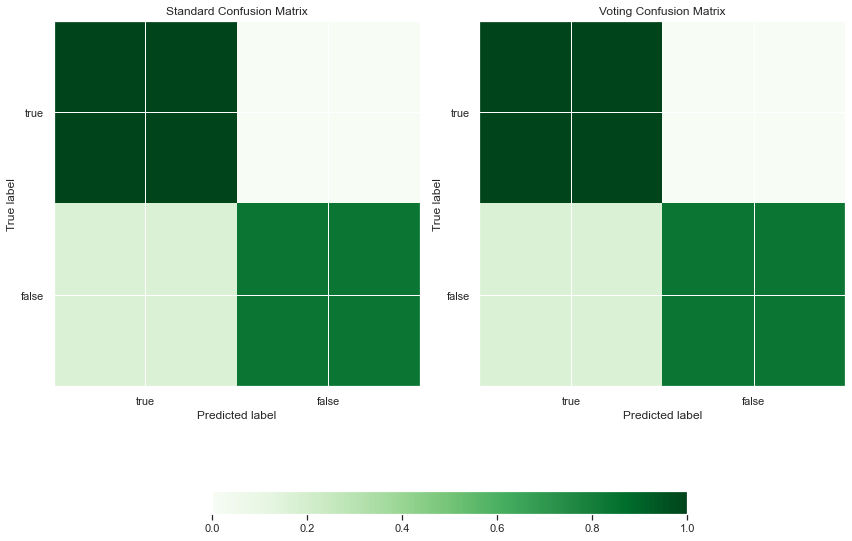

 Showing results for model  mlp_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.75      0.93      0.83       585		           0       0.75      0.93      0.83       585
           1       0.91      0.71      0.80       629		           1       0.91      0.71      0.80       629
		
    accuracy                           0.81      1214		    accuracy                           0.81      1214
   macro avg       0.83      0.82      0.81      1214		   macro avg       0.83      0.82      0.81      1214
weighted avg       0.83      0.81      0.81      1214		weighted avg       0.83      0.81      0.81      1214
		



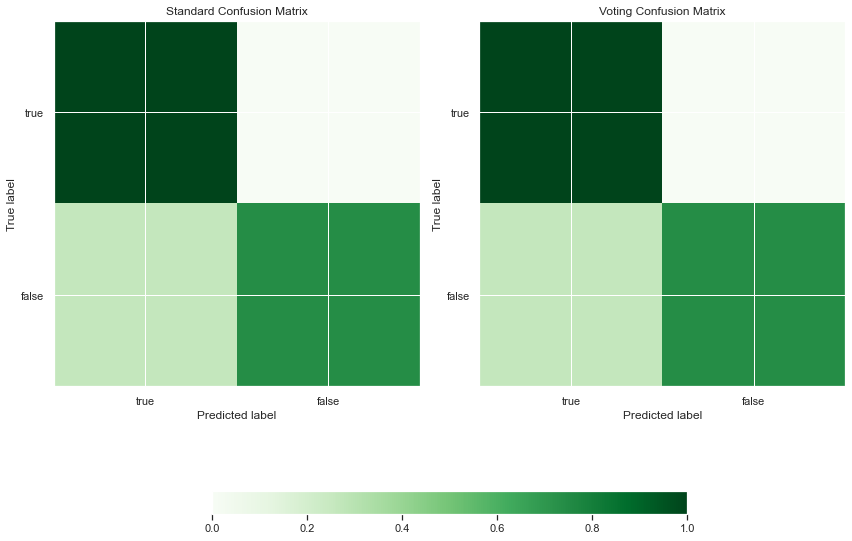

 Showing results for model  bag_of_vectors_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.74      0.87      0.80       585		           0       0.74      0.87      0.80       585
           1       0.85      0.72      0.78       629		           1       0.85      0.72      0.78       629
		
    accuracy                           0.79      1214		    accuracy                           0.79      1214
   macro avg       0.80      0.79      0.79      1214		   macro avg       0.80      0.79      0.79      1214
weighted avg       0.80      0.79      0.79      1214		weighted avg       0.80      0.79      0.79      1214
		



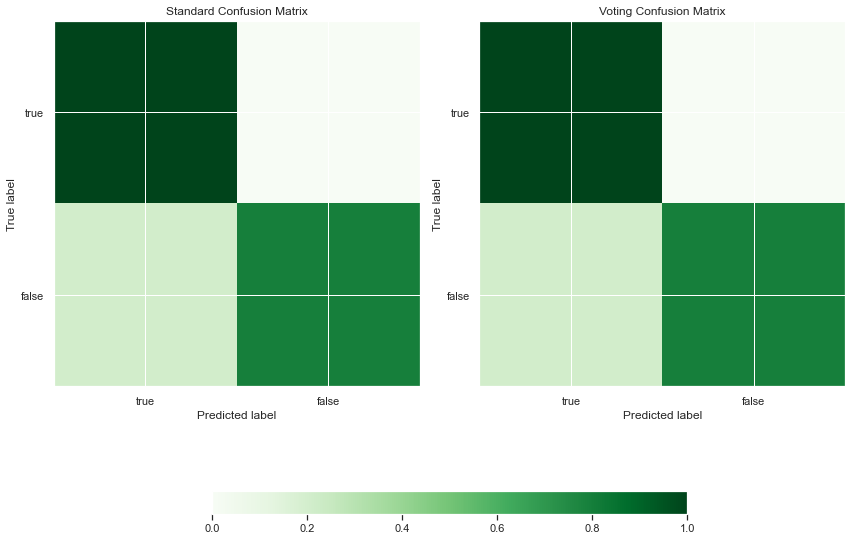

In [162]:
evaluation_of_the_models(models, histories)

We can notice some decent results for the last_stat_rnn_concat and mlp_concat models, therefore we are going to check if their predictions for the test dataset:

 Showing results for model  mlp_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.74      0.93      0.83       634		           0       0.74      0.93      0.83       634
           1       0.90      0.65      0.76       599		           1       0.90      0.65      0.76       599
		
    accuracy                           0.80      1233		    accuracy                           0.80      1233
   macro avg       0.82      0.79      0.79      1233		   macro avg       0.82      0.79      0.79      1233
weighted avg       0.82      0.80      0.79      1233		weighted avg       0.82      0.80      0.79      1233
		



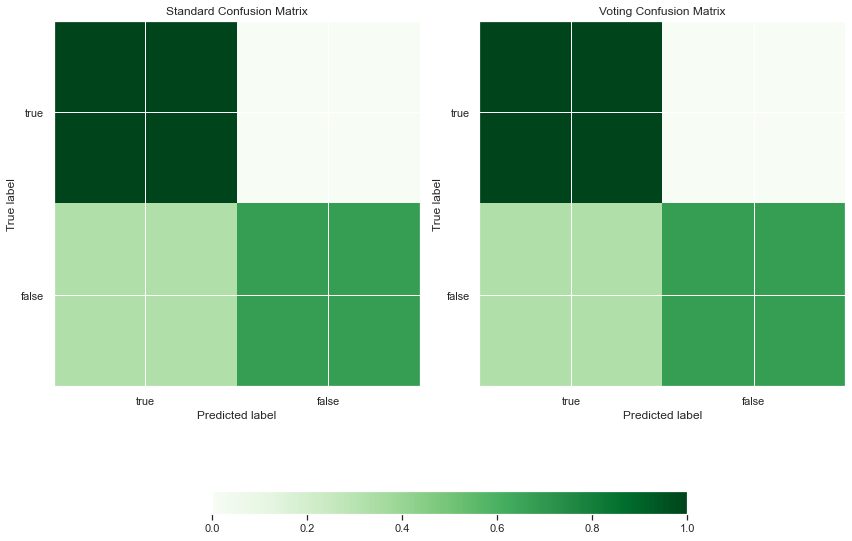

In [163]:
test(models['mlp_concat'])

 Showing results for model  last_state_rnn_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.76      0.87      0.81       634		           0       0.76      0.87      0.81       634
           1       0.84      0.71      0.77       599		           1       0.84      0.71      0.77       599
		
    accuracy                           0.79      1233		    accuracy                           0.79      1233
   macro avg       0.80      0.79      0.79      1233		   macro avg       0.80      0.79      0.79      1233
weighted avg       0.80      0.79      0.79      1233		weighted avg       0.80      0.79      0.79      1233
		



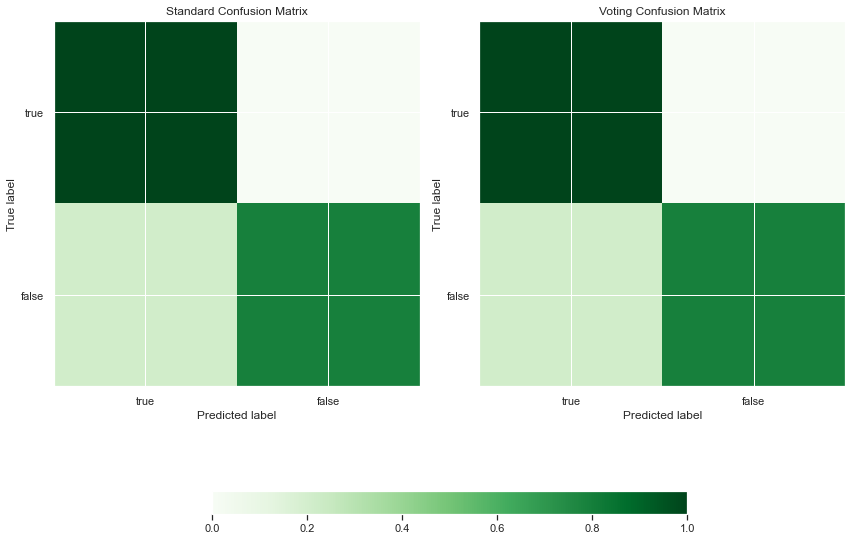

In [164]:
test(models['last_state_rnn_concat'])

### Observations:

We notice that the last_state_rnn and mlp modules are able to predict quite accurately the target of the test dataset. However we can notice that some targets are predicted as true even so they are in fact false. This defficiency can be cause by many parameters, but the fact that we simplified all the 'mixture' targets as 'false' might be a reasonable explanation. 

# Conclusion:

We managed to generate several models with a good accuracy (more than 80%) and at least two of these models predict the target of a test dataset with a decent precision, reaching a f1 score of about 80%.

## Where it can be improved:

1) We have been limited by the time needed to train some models (4h 25mins 48s for the last_state_rnn), therefore it was complicated to try new and more complex models. This is the result of a quite demanding model in addition to a limited network availibility.

2) We witness some overfitting when training our models, as shown by the val_loss that ramains quite high for some of our models. 

3) We made the assumption that 'mixture' and 'unproven' would mean 'false' 100% of the time, which can be changed.

## How YOU can improve it:

1) Have access to a faster network.

2) When runing your model, add dropout=0.3 (or 0.2 or 0.4 depending on the results), this layer should lower the overfitting.

3) You can keep 'mixture' as 'mixture' and 'unproven' as 'unproven' by changing the following lines:

    y_mapping = { 'unproven' : '3' , 'true' : '2' , 'mixture' : '1' , 'false' : '0'}

    class_weights = {i:class_weights[i] for i in range(4)}

    Then you will have to change the optimizer, the loss function since the targets are no longer binary, and adapt your model to the new shape of the targets.



